# **Important Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Prepare Dataset**

In [2]:
def prepare_data(data_dir):
    
    filepaths = []
    labels = []
    
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            filepath = os.path.join(foldpath, file)
            filepaths.append(filepath)
            labels.append(fold)
    
    df = pd.DataFrame(data={'filepaths': filepaths, 'labels': labels})
    return df

In [3]:
train_dir = '/kaggle/input/sports-balls-multiclass-image-classification/train'
train = prepare_data(train_dir)
print(f'Shape of train dataset {train.shape}')
train.head()

Shape of train dataset (7328, 2)


,filepaths,labels
0,/kaggle/input/sports-balls-multiclass-image-cl...,rugby_ball
1,/kaggle/input/sports-balls-multiclass-image-cl...,rugby_ball
2,/kaggle/input/sports-balls-multiclass-image-cl...,rugby_ball
3,/kaggle/input/sports-balls-multiclass-image-cl...,rugby_ball
4,/kaggle/input/sports-balls-multiclass-image-cl...,rugby_ball


In [4]:
test_dir = '/kaggle/input/sports-balls-multiclass-image-classification/test'
test = prepare_data(test_dir)
print(f'Shape of train dataset {test.shape}')
train.head()

Shape of train dataset (1841, 2)


,filepaths,labels
0,/kaggle/input/sports-balls-multiclass-image-cl...,rugby_ball
1,/kaggle/input/sports-balls-multiclass-image-cl...,rugby_ball
2,/kaggle/input/sports-balls-multiclass-image-cl...,rugby_ball
3,/kaggle/input/sports-balls-multiclass-image-cl...,rugby_ball
4,/kaggle/input/sports-balls-multiclass-image-cl...,rugby_ball


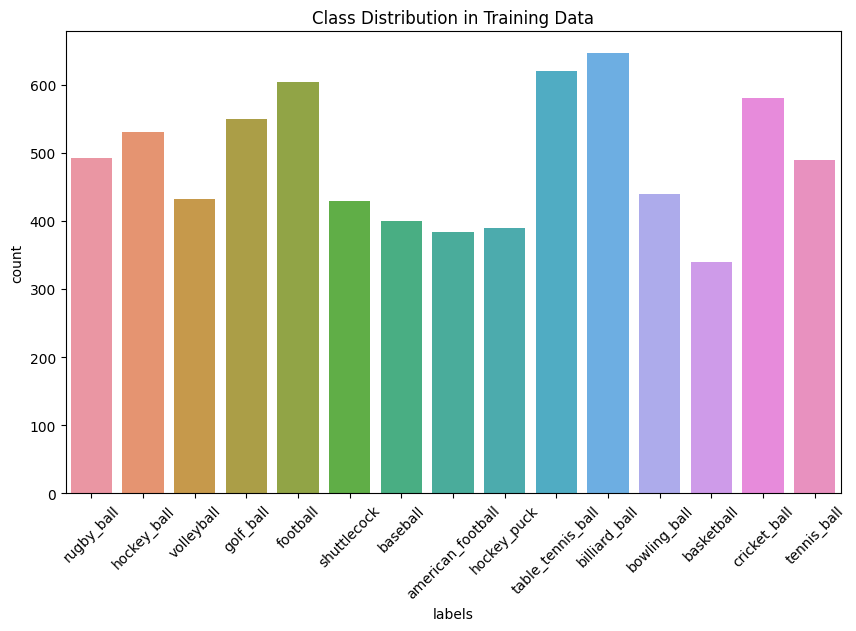

In [5]:
# Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='labels')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45)
plt.show()

In [6]:
# Split the test dataset into test and validation
train, validation = train_test_split(train, test_size=0.2, stratify=train['labels'], random_state=42)

In [7]:
batch_size = 16
img_size = (224, 224)

train_genenator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_genenator = ImageDataGenerator(
    rescale=1./255               
)

train_gen = train_genenator.flow_from_dataframe( 
    train, 
    x_col= 'filepaths',
    y_col= 'labels', 
    target_size= img_size, 
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= batch_size
)

valid_gen = test_genenator.flow_from_dataframe(
    validation, 
    x_col= 'filepaths', 
    y_col= 'labels', 
    target_size= img_size, 
    class_mode= 'categorical',
    color_mode= 'rgb', 
    shuffle= False, 
    batch_size= batch_size
)

test_gen = test_genenator.flow_from_dataframe(
    test,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size, 
    class_mode= 'categorical',
    color_mode= 'rgb', 
    shuffle= False, 
    batch_size= batch_size
)

Found 5862 validated image filenames belonging to 15 classes.
Found 1466 validated image filenames belonging to 15 classes.
Found 1841 validated image filenames belonging to 15 classes.


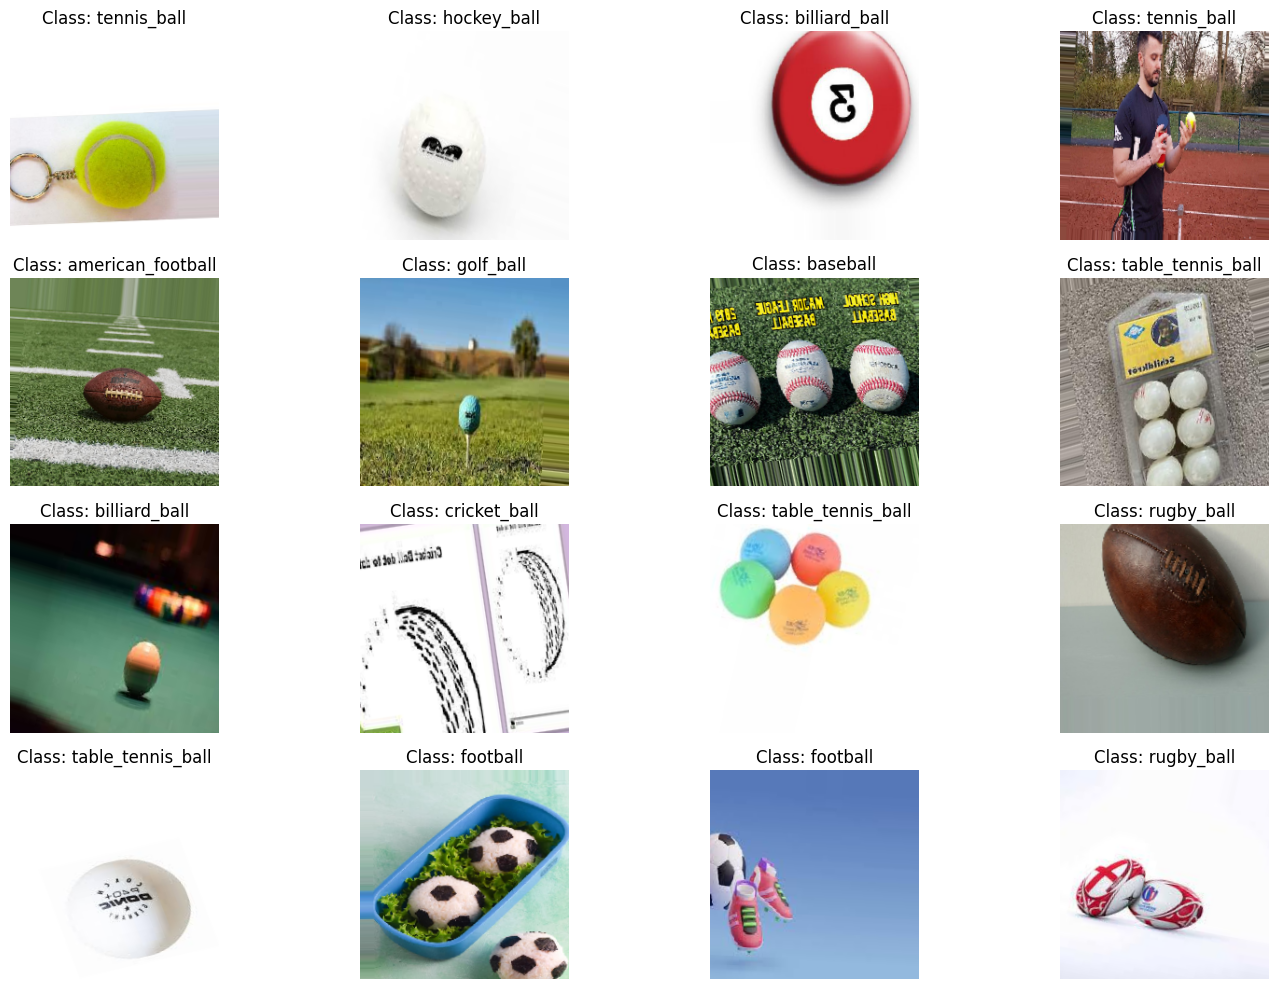

In [8]:
# Get samples from train data
images, labels = next(train_gen)
class_indices = np.argmax(labels, axis=1)

class_names = list(train_gen.class_indices.keys())

# Plot the images
plt.figure(figsize=(15, 10))
for i in range(min(batch_size, 16)): 
    plt.subplot(4, 4, i + 1) 
    plt.imshow(images[i])
    plt.title(f"Class: {class_names[class_indices[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Model**

In [9]:
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

# Load EfficientNetB3 pre-trained on ImageNet
base_model = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=img_shape
)

model = Sequential([
    base_model,
    Flatten(),
    
    Dense(256,activation = "relu"),
    Dropout(0.3),
    Dense(128,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 75264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      19,267,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,086,206 (114.77 MB)

 Trainable params: 29,998,903 (114.44 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [10]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_gen, 
    epochs=20, 
    validation_data=valid_gen, 
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


367/367 ━━━━━━━━━━━━━━━━━━━━ 262s 442ms/step - accuracy: 0.3827 - loss: 2.3175 - val_accuracy: 0.5116 - val_loss: 1.5836
Epoch 2/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 82s 220ms/step - accuracy: 0.7243 - loss: 0.9633 - val_accuracy: 0.8261 - val_loss: 0.5820
Epoch 3/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 82s 220ms/step - accuracy: 0.8105 - loss: 0.6613 - val_accuracy: 0.8799 - val_loss: 0.4392
Epoch 4/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.8405 - loss: 0.5585 - val_accuracy: 0.8649 - val_loss: 0.4787
Epoch 5/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.8670 - loss: 0.4601 - val_accuracy: 0.8922 - val_loss: 0.3838
Epoch 6/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.8794 - loss: 0.3999 - val_accuracy: 0.8929 - val_loss: 0.4393
Epoch 7/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 82s 220ms/step - accuracy: 0.8934 - loss: 0.3642 - val_accuracy: 0.8922 - val_loss: 0.4548
Epoch 8/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 82s 220ms/step - accuracy: 0.9186 - loss: 0.2923 - va

# **Evaluate the Model**

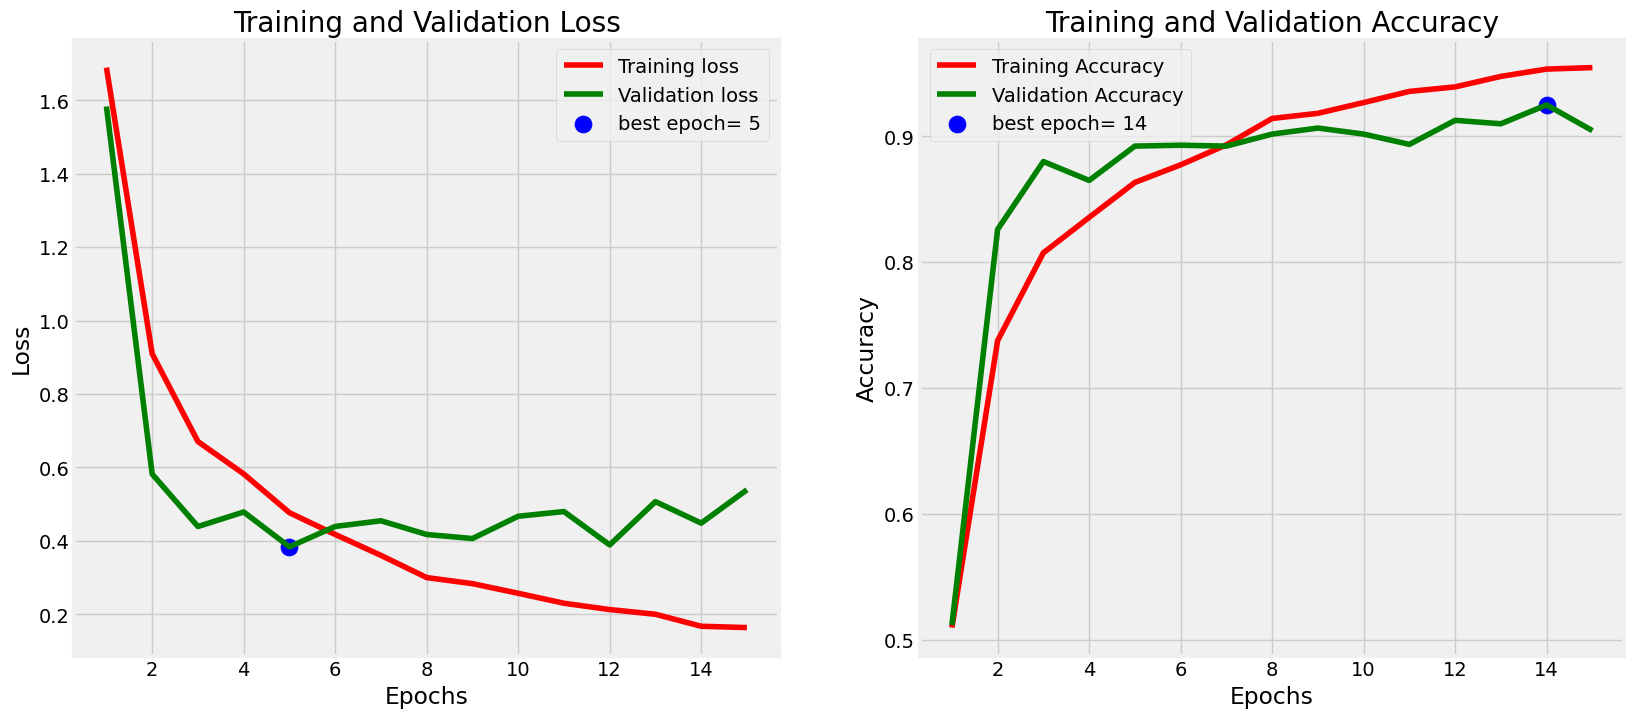

In [11]:
# Plot Accuracy and Loss
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [12]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

367/367 ━━━━━━━━━━━━━━━━━━━━ 79s 215ms/step - accuracy: 0.9532 - loss: 0.1635
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8839 - loss: 0.4302
  2/116 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9062 - loss: 0.4691  

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


116/116 ━━━━━━━━━━━━━━━━━━━━ 25s 217ms/step - accuracy: 0.8678 - loss: 0.5235
Train Loss:  0.16509194672107697
Train Accuracy:  0.9534288644790649
--------------------
Validation Loss:  0.38383978605270386
Validation Accuracy:  0.8922237157821655
--------------------
Test Loss:  0.4737388789653778
Test Accuracy:  0.8837588429450989


In [13]:
# Get Predictions
preds = model.predict(test_gen) 
y_pred = np.argmax(preds, axis=1) 
g_dict = test_gen.class_indices 
classes = list(g_dict.keys())

116/116 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step


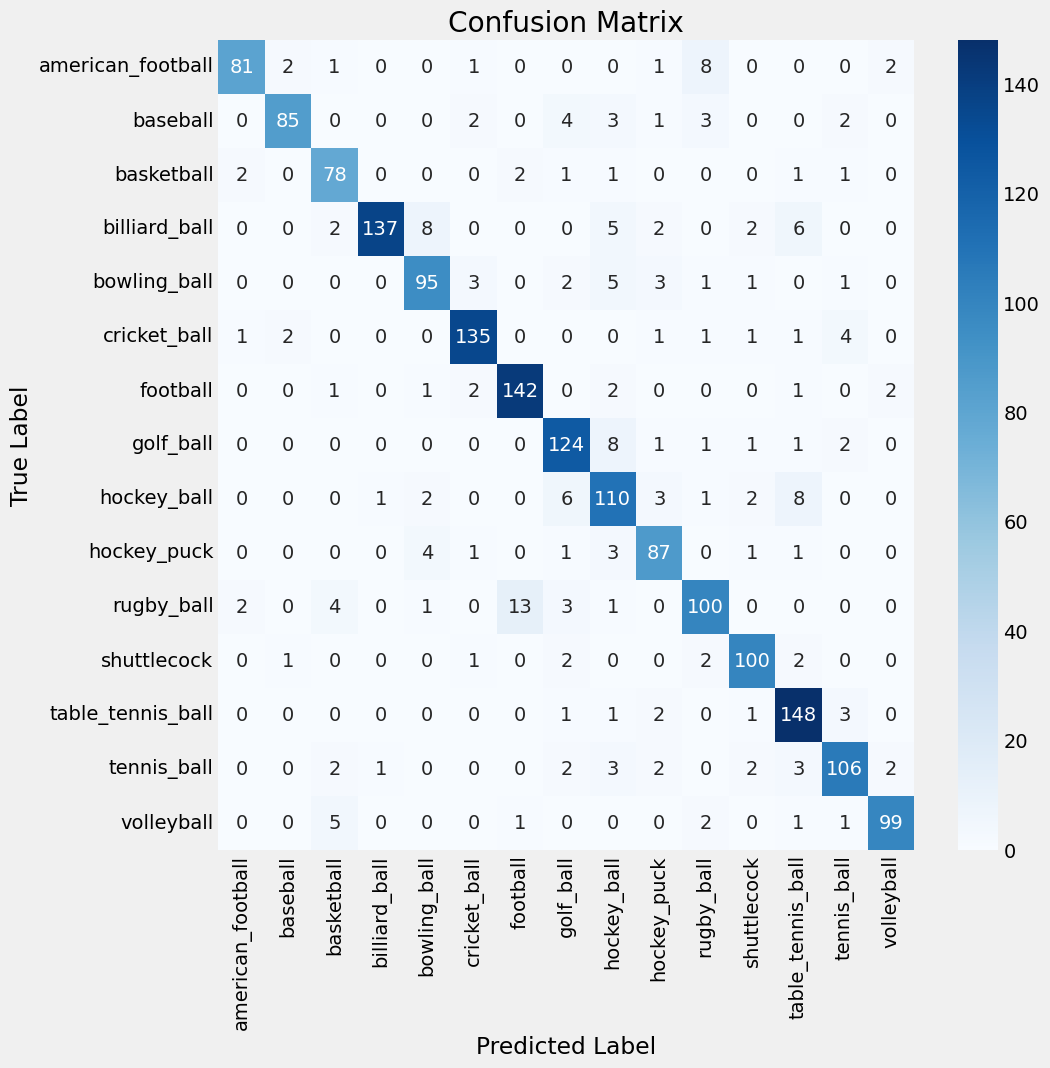

In [14]:
# Confusion Matrix
plt.figure(figsize=(10, 10))
cm = confusion_matrix(test_gen.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [15]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                   precision    recall  f1-score   support

american_football       0.94      0.84      0.89        96
         baseball       0.94      0.85      0.89       100
       basketball       0.84      0.91      0.87        86
    billiard_ball       0.99      0.85      0.91       162
     bowling_ball       0.86      0.86      0.86       111
     cricket_ball       0.93      0.92      0.93       146
         football       0.90      0.94      0.92       151
        golf_ball       0.85      0.90      0.87       138
      hockey_ball       0.77      0.83      0.80       133
      hockey_puck       0.84      0.89      0.87        98
       rugby_ball       0.84      0.81      0.82       124
      shuttlecock       0.90      0.93      0.91       108
table_tennis_ball       0.86      0.95      0.90       156
      tennis_ball       0.88      0.86      0.87       123
       volleyball       0.94      0.91      0.93       109

         accuracy                           0.88      

# **Save Model**

In [16]:
model.save('sports_balls_classification.h5')